# A Taylor Influence Model

Requirements:
- Python 3.11.7

In [58]:
from latex2sympy2 import latex2sympy
import sympy as sym
from sympy import *
from sympy.parsing.mathematica import parse_mathematica
from sympy import mathematica_code
import numpy as np

import scipy as sci
from scipy.integrate import odeint
import matplotlib.pyplot as plt 
import seaborn as sns

In [59]:
def round_expr(expr, num_digits=3): # Rounds sympy expressions to 3 decimal places
    return expr.xreplace({n : round(n, num_digits) for n in expr.atoms(Number)})

## Model specifics

We have (for $\mathbf{x} = [x_{1} \  x_{2} \  x_{3} \  x_{4} \  x_{5}]^{\intercal}$)

$$
\dot{\mathbf{x}} = 
    \begin{bmatrix}
        -.7 & .2 & 0 & .4 & 0 \\
        .2 & -1.6 & .2 & 0 & .6 \\
        .1 & .1 & -.3 & 0 & 0 \\
        .6 & 0 & 0 & -1.6 & .4 \\
        0 & .4 & 0 & .2 & -.7 \\
    \end{bmatrix}
    \mathbf{x} +
    \begin{bmatrix}
    -.1 \\
    .4 \\
    .-1 \\
    .4 \\
    -.1
    \end{bmatrix},
$$

and since we are treating all states as exposed, ($\mathbf{y} = [y_{1} \  y_{2} \  y_{3} \  y_{4} \  y_{5}]^{\intercal} = \mathbf{x}$):

$$
\dot{\mathbf{y}} = 
    \begin{bmatrix}
        -.7 & .2 & 0 & .4 & 0 \\
        .2 & -1.6 & .2 & 0 & .6 \\
        .1 & .1 & -.3 & 0 & 0 \\
        .6 & 0 & 0 & -1.6 & .4 \\
        0 & .4 & 0 & .2 & -.7 \\
    \end{bmatrix}
    \mathbf{y} +
    \begin{bmatrix}
    -.1 \\
    .4 \\
    -.1 \\
    .4 \\
    -.1
    \end{bmatrix}.
$$

Initial conditions are $x_0 = [.5 \ .5 \ 0 \ -.5 \ -.5]^{\intercal}$. This example specifies the existence of a _constant_ inhomogeneous term. A consequence is that what would traditionally be expressed as $B\mathbf{u}(t)$ is constant. 

In [60]:
x0, x1, x2, x3, x4  = sym.symbols('x0, x1, x2, x3, x4')
X = Matrix([x0, x1, x2, x3, x4])
X

Matrix([
[x0],
[x1],
[x2],
[x3],
[x4]])

In [61]:
X0_mat = Matrix([.5 , .5 , 0 , -.5, -.5])
X0_mat

Matrix([
[ 0.5],
[ 0.5],
[   0],
[-0.5],
[-0.5]])

In [62]:
A_mat = latex2sympy(r'$\displaystyle \left[\begin{matrix}-0.7 & 0.2 & 0 & 0.4 & 0\\0.2 & -1.6 & 0.2 & 0 & 0.6\\0.1 & 0.1 & -0.3 & 0 & 0\\0.6 & 0 & 0 & -1.6 & 0.4\\0 & 0.4 & 0 & 0.2 & -0.7\end{matrix} ]$')
A_mat

Matrix([
[-7/10,  1/5,     0,  2/5,     0],
[  1/5, -8/5,   1/5,    0,   3/5],
[ 1/10, 1/10, -3/10,    0,     0],
[  3/5,    0,     0, -8/5,   2/5],
[    0,  2/5,     0,  1/5, -7/10]])

In [63]:
nonhom_mat = Matrix([-.1 , .4 , -.1 , .4 , -.1 ])
nonhom_mat

Matrix([
[-0.1],
[ 0.4],
[-0.1],
[ 0.4],
[-0.1]])

In [64]:
A_mat * X + nonhom_mat

Matrix([
[     -7*x0/10 + x1/5 + 2*x3/5 - 0.1],
[x0/5 - 8*x1/5 + x2/5 + 3*x4/5 + 0.4],
[      x0/10 + x1/10 - 3*x2/10 - 0.1],
[     3*x0/5 - 8*x3/5 + 2*x4/5 + 0.4],
[      2*x1/5 + x3/5 - 7*x4/10 - 0.1]])

## Simulate the system and determine the equilibria

In [65]:
A = np.array(A_mat).astype(np.float64)
nonhom = np.array(nonhom_mat).astype(np.float64).squeeze()
X0 = np.array( X0_mat).astype(np.float64).squeeze()

def og_ode(x, t): 
    x_dot = np.matmul(A,x) + nonhom
    return x_dot

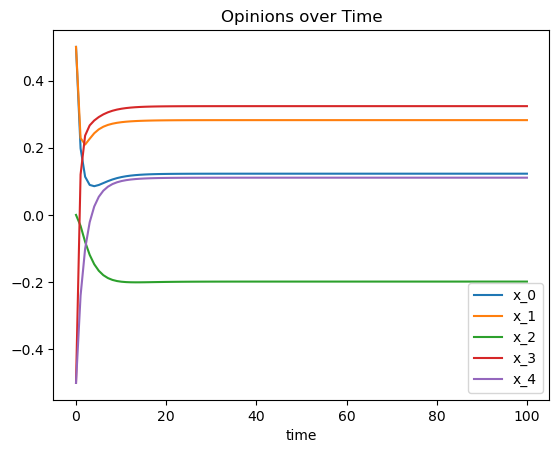

In [66]:
ts = np.linspace(0, 100, 100) # time steps
xs = odeint(og_ode, X0, ts)
plt.plot(ts, (xs[:,0]), label = "x_0")
plt.plot(ts, (xs[:,1]), label = "x_1")#, color='orange')
plt.plot(ts, (xs[:,2]), label = "x_2")#, color='green')
plt.plot(ts, (xs[:,3]), label = "x_3")#, color='orange')
plt.plot(ts, (xs[:,4]), label = "x_4")#, color='green')

plt.xlabel("time")
plt.legend()
plt.title('Opinions over Time')
plt.show()

In [67]:
# Equilibrium
xe = xs[-1].copy()
xe

array([ 0.12274025,  0.28211227, -0.19838249,  0.3237393 ,  0.11084681])

In [68]:
# Have to solve f(x,t) = 0 to get all equilibria in general
# In our case x' = f(x,t) = f(x) = Ax + b, so if A is invertible, then 0  = Axe + b <--> xe = -A^{-1}b.
A_mat_inv = A_mat**(-1)
A_mat_inv*A_mat # Test

Matrix([
[1, 0, 0, 0, 0],
[0, 1, 0, 0, 0],
[0, 0, 1, 0, 0],
[0, 0, 0, 1, 0],
[0, 0, 0, 0, 1]])

In [69]:
# Test, should evaluate to 0.
-(A_mat_inv * nonhom_mat) - Matrix(xe)

Matrix([
[3.66805891216515e-11],
[3.18988169212275e-11],
[8.09194655726486e-11],
[2.45267695042628e-11],
[3.94569654726951e-11]])

## Linearize around the equilibrium
Recall that

$x'(t) = f(x,t) = f(x) \approx f(x_e)+ f'(x_e)(x-x_e)  =  0 + A(x-x_e)$

In our case, $f(x) = A x + b $ with $A$ invertible and $x_e = -A^{-1}b$. It follows that $x' = f(x) =  A x + A (A^{-1} b) = A(x-x_e)$. In general, we take the Jacobian evaluated at our equilibrium point. In our case, the Jacobian is $A$ (a constant matrix). We proceed to check if the system is stable at its equilibrium. In this case, all eigenvalues ought to have negative real part.

In [70]:
np.linalg.eig(A)

EigResult(eigenvalues=array([-2.01211813, -1.67394446, -0.62971864, -0.2143623 , -0.36985647]), eigenvectors=array([[-0.30382578,  0.16740997,  0.7543019 , -0.33850954,  0.44279704],
       [ 0.56357666,  0.64792788, -0.21657153, -0.3177571 ,  0.09742839],
       [-0.01517132, -0.05934285, -0.16308765, -0.76632916, -0.77333634],
       [ 0.71484996, -0.73158398,  0.24081918, -0.25210393,  0.31675225],
       [-0.2807679 , -0.1158735 , -0.54729695, -0.36554746,  0.30993128]]))

## Translate the system around $x(0) = 0$
We need to use the change of variables $\tilde{x} = x-x_0$ so that our linearized model becomes: 
$$
\tilde{x}' = x' = A(x-x_e) = A(x-x_0 + x_0 - x_e) = A(\tilde{x} + x_0-x_e) = A\tilde{x} + Bu,
$$
where $Bu = A(x_0-x_e)$. However, we also know that $A x_e = A (-A^{-1} b) = -b$. Hence, $Bu = Ax_0 +b$. We proceed to set $B = I$ and $u =  Ax_0 +b$ for our DSF analysis. The decision to set $B = I$ is intentional. This is the system model as it appears to a potential malicious actor, not an artefact of the translation around $x_{e}$. Other choices of $B$ could equally have been made.

In [71]:
B_mat = sym.eye(5)
B_mat

Matrix([
[1, 0, 0, 0, 0],
[0, 1, 0, 0, 0],
[0, 0, 1, 0, 0],
[0, 0, 0, 1, 0],
[0, 0, 0, 0, 1]])

In [72]:
# In general, u(t). Here u is constant. 
u_mat = A_mat * X0_mat + nonhom_mat
u_mat

Matrix([
[-0.55],
[ -0.6],
[    0],
[  1.3],
[ 0.35]])

In [73]:
u = np.array(u_mat).astype(np.float64).squeeze() 
u

array([-0.55, -0.6 ,  0.  ,  1.3 ,  0.35])

## Transfer function
We have $A$ and $B$. We assumed that $C = I,  D= 0$, so we accordingly know that $y = x$.


In [74]:
C_mat = B_mat.copy() 

In general we have 
\begin{align*}
&\text{(transfer function in $X$)} &G_x(s) &= (sI-A)^{-1}B \\
&\text{(transfer function in $Y$)} &G_y(s) &= C(sI-A)^{-1}B + D
\end{align*}
In our case these are identical: simply $(sI-A)^{-1}$.

In [75]:
s = symbols('s')
G_mat = simplify( (s * sym.eye(5)-A_mat)**(-1) )
G_mat

Matrix([
[10*(2500*s**4 + 10500*s**3 + 14075*s**2 + 6445*s + 908)/(25000*s**5 + 122500*s**4 + 207250*s**3 + 144675*s**2 + 42255*s + 4204),              10*(500*s**3 + 1300*s**2 + 1025*s + 204)/(25000*s**5 + 122500*s**4 + 207250*s**3 + 144675*s**2 + 42255*s + 4204),                            20*(50*s**2 + 115*s + 68)/(25000*s**5 + 122500*s**4 + 207250*s**3 + 144675*s**2 + 42255*s + 4204),                20*(500*s**3 + 1300*s**2 + 805*s + 134)/(25000*s**5 + 122500*s**4 + 207250*s**3 + 144675*s**2 + 42255*s + 4204),                             20*(350*s**2 + 665*s + 164)/(25000*s**5 + 122500*s**4 + 207250*s**3 + 144675*s**2 + 42255*s + 4204)],
[                 20*(250*s**3 + 675*s**2 + 580*s + 131)/(25000*s**5 + 122500*s**4 + 207250*s**3 + 144675*s**2 + 42255*s + 4204), 25*(1000*s**4 + 3300*s**3 + 3310*s**2 + 1283*s + 168)/(25000*s**5 + 122500*s**4 + 207250*s**3 + 144675*s**2 + 42255*s + 4204),                50*(100*s**3 + 300*s**2 + 241*s + 56)/(25000*s**5 + 122500*s**4 + 207250*s**3 

## Dynamical structure function
Because $y=x$ and $B = I$, we get that
$$
Q = (sI-\text{diag}(A))^{-1}*(A-\text{diag}(A))
$$
where $P = (sI\text{diag}(A))^{-1}$.

In [76]:
# Diagonal of A
D_mat = diag(*[A_mat[i,i] for i in range(A_mat.shape[0])])
D_mat

Matrix([
[-7/10,    0,     0,    0,     0],
[    0, -8/5,     0,    0,     0],
[    0,    0, -3/10,    0,     0],
[    0,    0,     0, -8/5,     0],
[    0,    0,     0,    0, -7/10]])

In [77]:
lhs = s * sym.eye(5)-D_mat
rhs = A_mat - D_mat
lhs

Matrix([
[s + 7/10,       0,        0,       0,        0],
[       0, s + 8/5,        0,       0,        0],
[       0,       0, s + 3/10,       0,        0],
[       0,       0,        0, s + 8/5,        0],
[       0,       0,        0,       0, s + 7/10]])

In [78]:
rhs

Matrix([
[   0,  1/5,   0, 2/5,   0],
[ 1/5,    0, 1/5,   0, 3/5],
[1/10, 1/10,   0,   0,   0],
[ 3/5,    0,   0,   0, 2/5],
[   0,  2/5,   0, 1/5,   0]])

In [79]:
Q_mat = (lhs**(-1))*rhs
Q_mat # Q ought to be a hollow matrix

Matrix([
[                0,  1/(5*(s + 7/10)),               0, 2/(5*(s + 7/10)),               0],
[  1/(5*(s + 8/5)),                 0, 1/(5*(s + 8/5)),                0, 3/(5*(s + 8/5))],
[1/(10*(s + 3/10)), 1/(10*(s + 3/10)),               0,                0,               0],
[  3/(5*(s + 8/5)),                 0,               0,                0, 2/(5*(s + 8/5))],
[                0,  2/(5*(s + 7/10)),               0, 1/(5*(s + 7/10)),               0]])

In [80]:
P_mat = (lhs**(-1))*B_mat
P_mat

Matrix([
[1/(s + 7/10),           0,            0,           0,            0],
[           0, 1/(s + 8/5),            0,           0,            0],
[           0,           0, 1/(s + 3/10),           0,            0],
[           0,           0,            0, 1/(s + 8/5),            0],
[           0,           0,            0,           0, 1/(s + 7/10)]])

Now we seek the matrix $H = (I-Q)^{-1}$:

In [81]:
sym.eye(5)-Q_mat

Matrix([
[                 1,  -1/(5*(s + 7/10)),                0, -2/(5*(s + 7/10)),                0],
[  -1/(5*(s + 8/5)),                  1, -1/(5*(s + 8/5)),                 0, -3/(5*(s + 8/5))],
[-1/(10*(s + 3/10)), -1/(10*(s + 3/10)),                1,                 0,                0],
[  -3/(5*(s + 8/5)),                  0,                0,                 1, -2/(5*(s + 8/5))],
[                 0,  -2/(5*(s + 7/10)),                0, -1/(5*(s + 7/10)),                1]])

In [82]:
# Sympy computation for H: 
H = (sym.eye(5)-Q_mat)**(-1)
H_mat = simplify(H)
H_mat

Matrix([
[(25000*s**5 + 122500*s**4 + 214250*s**3 + 162975*s**2 + 54195*s + 6356)/(25000*s**5 + 122500*s**4 + 207250*s**3 + 144675*s**2 + 42255*s + 4204),               2*(2500*s**4 + 10500*s**3 + 15525*s**2 + 9220*s + 1632)/(25000*s**5 + 122500*s**4 + 207250*s**3 + 144675*s**2 + 42255*s + 4204),                             2*(500*s**3 + 1300*s**2 + 1025*s + 204)/(25000*s**5 + 122500*s**4 + 207250*s**3 + 144675*s**2 + 42255*s + 4204),                 4*(2500*s**4 + 10500*s**3 + 14425*s**2 + 7110*s + 1072)/(25000*s**5 + 122500*s**4 + 207250*s**3 + 144675*s**2 + 42255*s + 4204),                               2*(3500*s**3 + 9100*s**2 + 6295*s + 1148)/(25000*s**5 + 122500*s**4 + 207250*s**3 + 144675*s**2 + 42255*s + 4204)],
[                  2*(2500*s**4 + 8500*s**3 + 10525*s**2 + 5370*s + 917)/(25000*s**5 + 122500*s**4 + 207250*s**3 + 144675*s**2 + 42255*s + 4204), 5*(5000*s**5 + 24500*s**4 + 42950*s**3 + 32895*s**2 + 11104*s + 1344)/(25000*s**5 + 122500*s**4 + 207250*s**3 + 144675*s**2 

In [83]:
# Verify that H_mat*(I-Q_mat) = I 
a = np.arange(-1000, 1000, 10)*1j # These ought to reside on the imaginary axis
f = lambdify(s, H_mat * (eye(5)-Q_mat) - eye(5), "numpy") # We ought to obtain the zero matrix
abs(f(a).reshape(len(a)*(5**2))).max()

4.4007612802209857e-16

In [84]:
w = sym.Symbol('w', real=True)

In [85]:
from scipy.optimize import minimize_scalar

optima = {}
for i in range(H_mat.shape[0]):
    for j in range(H_mat.shape[1]):
        h  =  abs(H_mat[i,j].subs({s: I*w}))**2 # Substitute s = i w, then take |h|^2 (will be a Sympy function, maps R to R>=0)
        h_python = sym.lambdify(w, h, 'numpy')# Converts the SymPy function to a Python function
        result = minimize_scalar(lambda w: -h_python(w))# Use scipy.optimize.minimize_scalar to find the maximum
        argmax = result.x # The argmax (the point at which the maximum occurs)
        funmax = np.sqrt(-result.fun)
        optima[(i,j)] = {'argmax': argmax, 'funmax': funmax} 
        print(f'{i,j}:  \t (w_0, |h|(w_0)) = {(argmax, funmax)}')

(0, 0):  	 (w_0, |h|(w_0)) = (-1.4848029872799015e-09, 1.5118934348239772)
(0, 1):  	 (w_0, |h|(w_0)) = (1.8211032816222947e-11, 0.7764034253092292)
(0, 2):  	 (w_0, |h|(w_0)) = (1.5460243347114294e-11, 0.09705042816365365)
(0, 3):  	 (w_0, |h|(w_0)) = (-8.179041549820273e-10, 1.0199809705042817)
(0, 4):  	 (w_0, |h|(w_0)) = (-1.5351703507991256e-09, 0.5461465271170314)
(1, 0):  	 (w_0, |h|(w_0)) = (-5.0952239249195406e-11, 0.4362511893434824)
(1, 1):  	 (w_0, |h|(w_0)) = (1.3231402562551094e-11, 1.598477640342531)
(1, 2):  	 (w_0, |h|(w_0)) = (-1.4989583063489603e-09, 0.19980970504281637)
(1, 3):  	 (w_0, |h|(w_0)) = (1.6922058545603395e-11, 0.4529019980970504)
(1, 4):  	 (w_0, |h|(w_0)) = (-6.837281170472029e-11, 0.7126546146527117)
(2, 0):  	 (w_0, |h|(w_0)) = (1.105265847343127e-11, 0.6493815413891532)
(2, 1):  	 (w_0, |h|(w_0)) = (-2.2482760704179512e-10, 0.7916270218839201)
(2, 2):  	 (w_0, |h|(w_0)) = (-9.125361815983478e-10, 1.09895337773549)
(2, 3):  	 (w_0, |h|(w_0)) = (3.968

## Perturbing the (single) most vulnerable existing link

In [86]:
# In the context of an existing link perturbation, we ignore all the links that are represented as 0 in Q_mat.
keep_optima = {(i,j):v for ((i,j), v )in optima.items() if Q_mat[i,j] != 0}
keep_optima            

{(0, 1): {'argmax': 1.8211032816222947e-11, 'funmax': 0.7764034253092292},
 (0, 3): {'argmax': -8.179041549820273e-10, 'funmax': 1.0199809705042817},
 (1, 0): {'argmax': -5.0952239249195406e-11, 'funmax': 0.4362511893434824},
 (1, 2): {'argmax': -1.4989583063489603e-09, 'funmax': 0.19980970504281637},
 (1, 4): {'argmax': -6.837281170472029e-11, 'funmax': 0.7126546146527117},
 (2, 0): {'argmax': 1.105265847343127e-11, 'funmax': 0.6493815413891532},
 (2, 1): {'argmax': -2.2482760704179512e-10, 'funmax': 0.7916270218839201},
 (3, 0): {'argmax': -1.4347473525171853e-09, 'funmax': 0.6776879162702188},
 (3, 4): {'argmax': -1.2354813653134092e-09, 'funmax': 0.5994291151284491},
 (4, 1): {'argmax': -1.433162789110748e-09, 'funmax': 1.0732635585156993},
 (4, 3): {'argmax': 1.4104847138254258e-11, 'funmax': 0.7040913415794482}}

In [87]:
sorted([(i,j, v["argmax"], v["funmax"]) for ((i,j), v) in keep_optima.items() ], reverse=True, key = lambda x: x[-1])

[(4, 1, -1.433162789110748e-09, 1.0732635585156993),
 (0, 3, -8.179041549820273e-10, 1.0199809705042817),
 (2, 1, -2.2482760704179512e-10, 0.7916270218839201),
 (0, 1, 1.8211032816222947e-11, 0.7764034253092292),
 (1, 4, -6.837281170472029e-11, 0.7126546146527117),
 (4, 3, 1.4104847138254258e-11, 0.7040913415794482),
 (3, 0, -1.4347473525171853e-09, 0.6776879162702188),
 (2, 0, 1.105265847343127e-11, 0.6493815413891532),
 (3, 4, -1.2354813653134092e-09, 0.5994291151284491),
 (1, 0, -5.0952239249195406e-11, 0.4362511893434824),
 (1, 2, -1.4989583063489603e-09, 0.19980970504281637)]

In [88]:
# We see that the existing link (i,j) that is most vulnerable (highest \|H_{i,j}\|) has index:
i = 4
j = 1
omega_0 = 0

The most vulnerable existing-link has index (4,1) (recall that Python indexing begins at 0). This signifies that the perturbation will observe the sentiment of Agent 5 and influence the sentiment of Agent 2.

In [89]:
# For the vunerable link, compute its norm and find the phase.
h_val = H_mat[i,j].subs({s:omega_0*I}).simplify()
h_val

1128/1051

In [90]:
1128/1051 - 1.073 # This ought to evaluate as approximately 0.

0.00026355851569936917

We propose $\delta = \frac{(1-s)^2}{r(s+1)^2} = \frac{1051(1-s)}{1128(s+1)}$ where $r= \|H[4,1]\| = 1128/1051 ~= 1.073$. We proceed to construct $\Delta \in \mathbb{C}^{5\times5}$ satisfying:
- $[\Delta]_{ji} = \delta(s)$.
- $\Delta$ is analytic on $\mathbb{C}^{+}$.
- $\|\Delta \| = \Delta(s=i\omega_0) = 1/r$ (minimal norm). 
- $\|\Delta\|_{H^{\infty}} < \infty$.
- The system is destabilized (an eigenvalue of $\Delta$ satisfies $\lambda \gtrapprox 0$).
    

In [91]:
s, t = sym.symbols('s, t')
Delta = sym.zeros(5)
Delta[j,i] = (1+.001)*((1051)*(1-s)**2)/(1128 * (1+s)**2) # We introduce (1 + \epsilon) to obtain a slightly super-minimal case.
Delta

Matrix([
[0, 0, 0, 0,                                       0],
[0, 0, 0, 0, 0.932669326241135*(1 - s)**2/(s + 1)**2],
[0, 0, 0, 0,                                       0],
[0, 0, 0, 0,                                       0],
[0, 0, 0, 0,                                       0]])

We proceed to unwind the DSF and interpret the effect of the perturbation on the original system. Here since $x = y$ and $Bu = u$, $B = I$ we have that $Q = A$, $D = diag(A)$. This is described by:
\begin{align*}
&&Y &= (Q + \Delta)Y + PU \nonumber \\
&&&= (sI - D)^{-1}[((A - D) + (sI - D)\Delta)Y + U] \nonumber \\
&\implies &sY &= AY + (sI - D)(\Delta)Y + U \nonumber \\
\end{align*}

In [92]:
MAT = (s*eye(5)-D_mat)*Delta
MAT

Matrix([
[0, 0, 0, 0,                                                 0],
[0, 0, 0, 0, 0.932669326241135*(1 - s)**2*(s + 8/5)/(s + 1)**2],
[0, 0, 0, 0,                                                 0],
[0, 0, 0, 0,                                                 0],
[0, 0, 0, 0,                                                 0]])

In [93]:
apart(MAT[j,i])

0.932669326241135*s - 2.23840638297872 + 1.49227092198582/(s + 1) + 2.23840638297872/(s + 1)**2

In [94]:
apart(MAT[j,i]).n()

0.932669326241135*s - 2.23840638297872 + 1.49227092198582/(s + 1.0) + 2.23840638297872/(s + 1.0)**2

(Now counting from 1 to 5): so our $\dot{x_2}$ becomes: 
\begin{align*}
& .2x_1 -1.6x_2 + .2x_3 + .6 x_5 + \text{new terms}\\ 
=& .2x_1 -1.6x_2 + .2x_3 + .6 x_5 +  (1051)/(1128)\dot{x_5} - (1051 / 470) x_5  + (1051 / 705) (e^{-t}*x_5)+ (1051 / 470)(te^{-t}*x_5)\\
=& .2x_1 -1.6x_2 + .2x_3 + .6 x_5 +  (1051)/(1128)[.4x_2+.2x_4 -.7x_5] - (1051 / 470) x_5  + (1051 / 705) (e^{-t}*x_5)+ (1051 / 470)(te^{-t}*x_5)
\end{align*}

In [95]:
A_mat_new = np.hstack([np.vstack([A[0,:], A[1,:] + (0.932669326241135)*A[-1,:] - [0,0,0,0,2.23840638297872], A[2:], [0,0,0,0,1], [0,0,0,0,0]]), np.array([0,1.49227092198582,0,0,0,-1,1]).reshape(7,1), np.array([0,2.23840638297872,0,0,0,0,-1]).reshape(7,1)])

In [96]:
# round_expr(sym.Matrix(A_mat_new))
sym.Matrix(A_mat_new)

Matrix([
[-0.7,               0.2,    0,               0.4,                 0,                0,                0],
[ 0.2, -1.22693226950355,  0.2, 0.186533865248227, -2.29127491134751, 1.49227092198582, 2.23840638297872],
[ 0.1,               0.1, -0.3,                 0,                 0,                0,                0],
[ 0.6,                 0,    0,              -1.6,               0.4,                0,                0],
[   0,               0.4,    0,               0.2,              -0.7,                0,                0],
[   0,                 0,    0,                 0,               1.0,             -1.0,                0],
[   0,                 0,    0,                 0,                 0,              1.0,             -1.0]])

In [97]:
for k in Matrix(A_mat_new).eigenvals().keys(): 
    # print(round_expr(k))
    print(k)

-1.12365558635965 - 1.17479062096381*I
-1.12365558635965 + 1.17479062096381*I
0.000130740802974091
-0.307732606028666
-0.538031577729211
-1.80943884219232
-1.62454881163703


We have a small positive eigenvalue (orders of magnitude larger than before the perturbation was applied), so the perturbation away from zero was successful.

## Consider perturbing the (single) most vulnerable link

We proceed to investigate the minimal created-link perturbation. This differs from the previous case in that we are no longer constrained to the modification of network links that already materially exist.

In [98]:
# Determine the link (i,j) with maximal norm \|H(i,j)\|, and the \argmax{s} = i\omega_0
sorted([(i,j, v["argmax"], v["funmax"]) for ((i,j), v) in optima.items() ], reverse=True, key = lambda x: x[-1])

[(1, 1, 1.3231402562551094e-11, 1.598477640342531),
 (4, 4, -1.3245403959641692e-09, 1.5784966698382492),
 (3, 3, -9.012567359729585e-10, 1.5585156993339677),
 (0, 0, -1.4848029872799015e-09, 1.5118934348239772),
 (2, 2, -9.125361815983478e-10, 1.09895337773549),
 (4, 1, -1.433162789110748e-09, 1.0732635585156993),
 (0, 3, -8.179041549820273e-10, 1.0199809705042817),
 (2, 1, -2.2482760704179512e-10, 0.7916270218839201),
 (0, 1, 1.8211032816222947e-11, 0.7764034253092292),
 (1, 4, -6.837281170472029e-11, 0.7126546146527117),
 (4, 3, 1.4104847138254258e-11, 0.7040913415794482),
 (3, 0, -1.4347473525171853e-09, 0.6776879162702188),
 (2, 0, 1.105265847343127e-11, 0.6493815413891532),
 (3, 4, -1.2354813653134092e-09, 0.5994291151284491),
 (3, 1, 1.6890273572918936e-11, 0.5594671741198858),
 (0, 4, -1.5351703507991256e-09, 0.5461465271170314),
 (2, 3, 3.9689546092663574e-11, 0.49096098953377737),
 (1, 3, 1.6922058545603395e-11, 0.4529019980970504),
 (4, 0, -4.021101581134632e-10, 0.442911512

In [99]:
# We see that the link (i,j) that is most vulnerable (maximal \|H{i,j}\|) has index
i = 1
j = 1
omega_0 = 0

The most vulnerable existing-link has index (1,1) (recall that Python indexing begins at 0). This signifies that the perturbation will observe the sentiment of Agent 2 and influence the sentiment of Agent 2. The perturbation will alter the self-influence of Agent-2!

In [100]:
# For the vunerable link, compute its norm and find the phase.
h_val = H_mat[i,j].subs({s:omega_0*I}).simplify()
h_val

1680/1051

In [101]:
1680/1051 - 1.598 # Ought to be approximately 0

0.0004776403425308384

We can use $\delta = \frac{(1-s)^2}{r(s+1)^2} = \frac{1051(1-s)}{1680(s+1)}$ where $r:= \|H[1,1]\| = 1680/1051 ~= 1.598$. We proceed to construct $\Delta \in \mathbb{C}^{5\times5}$ satisfying:

- $[\Delta]_{ji} = \delta(s)$.
- $\Delta$ is analytic on $\mathbb{C}^{+}$.
- $\|\Delta \| = \Delta(s=i\omega_0) = 1/r$ (minimal norm). 
- $\|\Delta\|_{H^{\infty}} < \infty$.
- The system is destabilized (an eigenvalue of $\Delta$ satisfies $\lambda \gtrapprox 0$).

In [102]:
s = sym.symbols('s')
lc_max_ind = (1, 1)

delta = (1+.001)*((1051)*(1-s)**2)/(1680*(1+s)**2) # We introduce (1 + \epsilon) to obtain a slightly super-minimal case.

Delta = ((s*np.eye(A.shape[0]) - np.diagflat(A.diagonal()))*delta)[lc_max_ind[1], lc_max_ind[0]]
Delta

0.626220833333333*(1 - s)**2*(1.0*s + 1.6)/(s + 1)**2

In [103]:
apart(Delta)

0.626220833333333*s - 1.50293 + 1.00195333333333/(s + 1) + 1.50293/(s + 1)**2

In [104]:
nsimplify(apart(Delta))

626220833333333*s/1000000000000000 - 150293/100000 + 100195333333333/(100000000000000*(s + 1)) + 150293/(100000*(s + 1)**2)

These are not nice fractions.

In [105]:
perturb_row = (1/(1-0.626220833333333))*(A[1,:] + [0,-1.50293,0,0,0]) # Careful here
A_perturb = np.hstack([np.vstack([A[0,:], perturb_row, A[2:], [0,1,0,0,0], [0,0,0,0,0]]), np.array([0,(1/(1-0.626220833333333))*1.00195333333333,0,0,0,-1,1]).reshape(7,1), np.array([0,(1/(1-0.626220833333333))*1.50293,0,0,0,0,-1]).reshape(7,1)])

In [106]:

# round_expr(sym.Matrix(A_mat_new))
Matrix(A_perturb)

Matrix([
[             -0.7,               0.2,                 0,  0.4,                0,                0,                0],
[0.535075300701171, -8.30150601402343, 0.535075300701171,    0, 1.60522590210351, 2.68060240560936, 4.02090360841406],
[              0.1,               0.1,              -0.3,    0,                0,                0,                0],
[              0.6,                 0,                 0, -1.6,              0.4,                0,                0],
[                0,               0.4,                 0,  0.2,             -0.7,                0,                0],
[                0,               1.0,                 0,    0,                0,             -1.0,                0],
[                0,                 0,                 0,    0,                0,              1.0,             -1.0]])

In [107]:
# Eigenvalues
for k in Matrix(A_perturb).eigenvals().keys(): 
    # print(round_expr(k))
    print(k)

-8.68269356682205
0.000172681198270726
-0.319613904299335
-0.451590228223006
-0.706411409322067
-1.85419328015300
-1.58717630640224


We have a small positive eigenvalue (orders of magnitude larger than before), so the perturbation away from zero was successful.

# Plotting

In [108]:
viridis = sns.color_palette("viridis", 10)
plasma_r = sns.color_palette("plasma_r", 10)
autumn = sns.color_palette(palette='autumn', n_colors = 10)
spring = sns.color_palette(palette='spring', n_colors = 10)
winter =sns.color_palette(palette='winter', n_colors = 10)

## Stable System

In [109]:
def ode(x, t): 
    a = x[0]
    b = x[1]
    c = x[2]
    d = x[3]
    e = x[4]
    
    adot = -.7*a + .2*b + .4*d - .1
    bdot = .2*a - 1.6*b + .2*c + .6*e + .4
    cdot = .1*a + .1*b - .3*c - .1
    ddot = .6*a - 1.6*d + .4*e + .4
    edot = .4*b + .2*d - .7*e - .1

    return adot, bdot, cdot, ddot, edot

In [110]:
# Equilibrium: 
xe = xs[-1]
xe

array([ 0.12274025,  0.28211227, -0.19838249,  0.3237393 ,  0.11084681])

In [111]:
ode(xe, 1) # Should be 0 vector

(9.485953689214455e-12,
 3.8439251781596795e-12,
 1.7417900455285462e-11,
 1.4516166046973922e-12,
 9.954995161542968e-12)

### Plotting

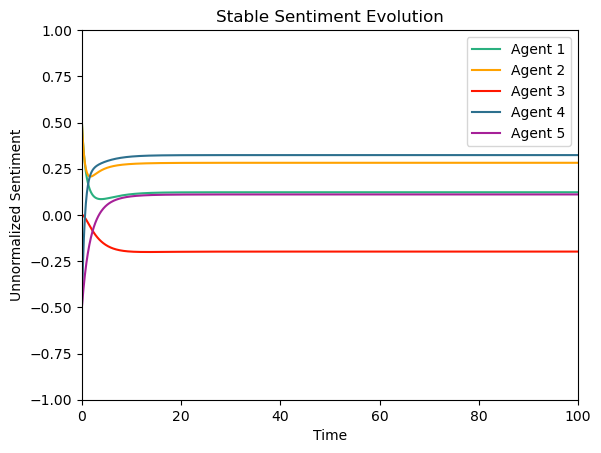

In [112]:
ts = np.linspace(0, 100, 1000) # Start, end, steps
x0 = [.5, .5, 0, -.5, -.5]

xs = sci.integrate.odeint(ode, x0, ts)

ax = plt.gca()
ax.set_xlim([0, 100])
ax.set_ylim([-1, 1])

plt.plot(ts, (xs[:,0]), label = "Agent 1", color=viridis[-4])
plt.plot(ts, (xs[:,1]), label = "Agent 2", color=autumn[-4])
plt.plot(ts, (xs[:,2]), label = "Agent 3", color=autumn[0])
plt.plot(ts, (xs[:,3]), label = "Agent 4", color=viridis[3])
plt.plot(ts, (xs[:,4]), label = "Agent 5", color=plasma_r[-4])

plt.xlabel("Time")
plt.ylabel("Unnormalized Sentiment")
plt.legend()
plt.title('Stable Sentiment Evolution')
plt.show()

## Existing Link Perturbation

### (Super-minimal perturbation)

In [113]:
def perturbed_ode(x, t): # Toggle existence of t variable depending on usage
    a = x[0]
    b = x[1]
    c = x[2]
    d = x[3]
    e = x[4]
    f = x[5]
    g = x[6]
    
    adot = -.7*a + .2*b + .4*d - .1
    bdot = .2*a - 1.22693226950355*b + .2*c + 0.186533865248227*d - 2.29127491134751*e + 1.49227092198582*f + 2.23840638297872*g + .4
    cdot = .1*a + .1*b - .3*c - .1
    ddot = .6*a - 1.6*d + .4*e + .4
    edot = .4*b + .2*d - .7*e - .1
    fdot = e - f
    gdot = f - g
    
    return adot, bdot, cdot, ddot, edot, fdot ,gdot

### Plotting

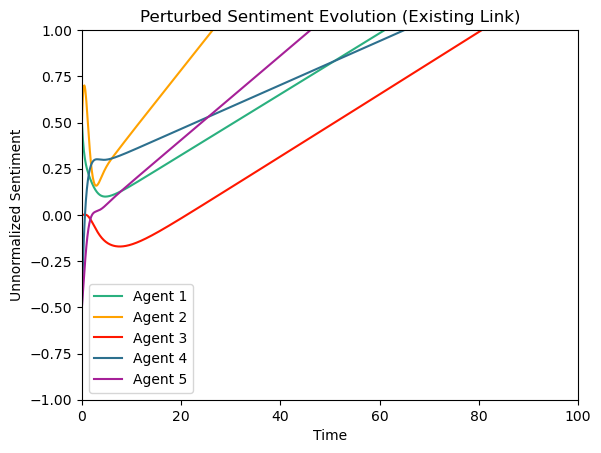

In [114]:
ts = np.linspace(0, 100, 1000) # Start, end, steps
x0 = [.5, .5, 0, -.5, -.5, 0, 0] # f(0) = ? g(0) = ? I think the convolution terms 0 out at t=0.

xs = sci.integrate.odeint(perturbed_ode, x0, ts)

ax = plt.gca()
ax.set_xlim([0, 100])
ax.set_ylim([-1, 1])

plt.plot(ts, (xs[:,0]), label = "Agent 1", color=viridis[-4])
plt.plot(ts, (xs[:,1]), label = "Agent 2", color=autumn[-4]) # Agent 2 peaks around 40000, everyone then crashes out to 0 (under original initial condition)
plt.plot(ts, (xs[:,2]), label = "Agent 3", color=autumn[0])
plt.plot(ts, (xs[:,3]), label = "Agent 4", color=viridis[3])
plt.plot(ts, (xs[:,4]), label = "Agent 5", color=plasma_r[-4])

plt.xlabel("Time")
plt.ylabel("Unnormalized Sentiment")
plt.legend()
plt.title('Perturbed Sentiment Evolution (Existing Link)')
plt.show()

## Link Creation Perturbation

### (Super-minimal perturbation)

In [115]:
def super_perturbed_ode(x, t): # Toggle existence of t variable depending on usage
    a = x[0]
    b = x[1]
    c = x[2]
    d = x[3]
    e = x[4]
    f = x[5]
    g = x[6]
    
    adot = -.7*a + .2*b + .4*d - .1
    bdot = 0.535075300701171*a - 8.30150601402343*b + 0.535075300701171*c  + 1.60522590210351*e + 2.68060240560936*f + 4.02090360841406*g + .4
    cdot = .1*a + .1*b - .3*c - .1
    ddot = .6*a - 1.6*d + .4*e + .4
    edot = .4*b + .2*d - .7*e - .1
    fdot = b - f
    gdot = f - g
    
    return adot, bdot, cdot, ddot, edot, fdot ,gdot


### Plotting

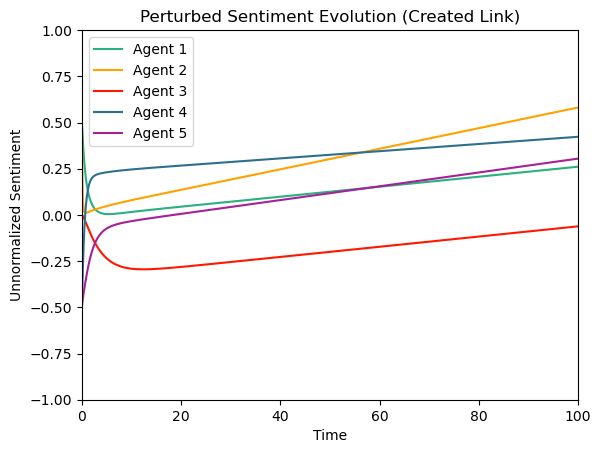

In [116]:
ts = np.linspace(0, 100, 100000) # Start, end, steps
x0 = [.5, .5, 0, -.5, -.5, 0, 0] # f(0) = ? g(0) = ? I think the convolution terms 0 out at t=0 no matter the initial condition of concern (the convolved variable).

xs = sci.integrate.odeint(super_perturbed_ode, x0, ts)

ax = plt.gca()
ax.set_xlim([0, 100])
ax.set_ylim([-1, 1])

plt.plot(ts, (xs[:,0]), label = "Agent 1", color=viridis[-4])
plt.plot(ts, (xs[:,1]), label = "Agent 2", color=autumn[-4]) # Agent 2 peaks around 40000, everyone then crashe out to 0 (under original initial condition)
plt.plot(ts, (xs[:,2]), label = "Agent 3", color=autumn[0])
plt.plot(ts, (xs[:,3]), label = "Agent 4", color=viridis[3])
plt.plot(ts, (xs[:,4]), label = "Agent 5", color=plasma_r[-4])

plt.xlabel("Time")
plt.ylabel("Unnormalized Sentiment")
plt.legend()
plt.title('Perturbed Sentiment Evolution (Created Link)')
plt.show()